<a href="https://colab.research.google.com/github/Jacqueline45/EE559_Project/blob/main/SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!unzip /content/EE559_Project-main.zip


Archive:  /content/EE559_Project-main.zip
cd4e0a51e0b87e7bb5bd032f2efedcc9a0da1845
   creating: EE559_Project-main/
  inflating: EE559_Project-main/.DS_Store  
 extracting: EE559_Project-main/.gitignore  
  inflating: EE559_Project-main/Feature_Selection.py  
  inflating: EE559_Project-main/MSE.py  
  inflating: EE559_Project-main/README.md  
  inflating: EE559_Project-main/baseline.py  
   creating: EE559_Project-main/cf_matrix_plots/
  inflating: EE559_Project-main/cf_matrix_plots/MSE.png  
  inflating: EE559_Project-main/cf_matrix_plots/MSE_val.png  
  inflating: EE559_Project-main/cf_matrix_plots/baseline_system.png  
  inflating: EE559_Project-main/cf_matrix_plots/baseline_system_val.png  
  inflating: EE559_Project-main/cf_matrix_plots/kNN_SMOTE_k=5.png  
  inflating: EE559_Project-main/cf_matrix_plots/kNN_SMOTE_k=7.png  
  inflating: EE559_Project-main/cf_matrix_plots/kNN_add_1_feat_k=5.png  
  inflating: EE559_Project-main/cf_matrix_plots/kNN_add_1_feat_k=7.png  
  inflating: E

In [2]:
import pandas as pd 
import imblearn
import numpy as np 

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

In [3]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generates all performance measures

import pandas as pd

from statistics import mean
import pandas as pd

def Add_feat(X_tr, X_test):
    mean_ISI_tr = [0,0,0,0]
    mean_ISI_test = [0,0,0,0]
    for i in range(4, X_tr.shape[0]-4):
        mean_ISI_tr.append(mean(X_tr['ISI'][i-4:i]))

    for i in range(4, X_test.shape[0]):
        mean_ISI_test.append(mean(X_test['ISI'][i-4:i]))

    mean_ISI_tr.extend([0,0,0,0])

    X_test = X_test.reset_index(drop=True)
    mean_ISI_test[0] = sum(X_tr['ISI'].iloc[-4:])/4
    mean_ISI_test[1] = (sum(X_tr['ISI'].iloc[-3:])+X_test['ISI'].iloc[0])/4
    mean_ISI_test[2] = (sum(X_tr['ISI'].iloc[-2:])+sum(X_test['ISI'].iloc[:2]))/4
    mean_ISI_test[3] = (X_tr['ISI'].iloc[X_tr.shape[0]-1]+sum(X_test['ISI'].iloc[:3]))/4
    
    X_tr = X_tr.assign(mean_ISI = mean_ISI_tr)
    X_test = X_test.assign(mean_ISI = mean_ISI_test)
    
    X_tr = X_tr.drop(X_tr.index[:4])
    X_tr = X_tr.drop(X_tr.index[-4:])

    X_tr = X_tr.reset_index(drop=True)

    return X_tr, X_test

def read_data(file):
    """Reads a CSV file and returns a data matrix and the labels separatelly"""
    data = pd.read_csv(file)
    return data.iloc[:, :-1], data.iloc[:,-1]

def metrics(true_labels, pred_labels, plot_title, work='test'):
    cf_matrix = confusion_matrix(true_labels, pred_labels)
    TP, TN, FP, FN = cf_matrix[1][1], cf_matrix[0][0], cf_matrix[0][1], cf_matrix[1][0]
    Recall = TP/(TP+FN)
    Precision = TP/(TP+FP)
    F1_score = 2*Recall*Precision/(Recall+Precision)
    Accuracy = (TP+TN)/true_labels.shape[0]
    
    if work == 'test':
        ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

        ax.set_title(plot_title)
        ax.set_xlabel('Predicted Values')
        ax.set_ylabel('Actual Values ')

        ax.xaxis.set_ticklabels(['0','1'])
        ax.yaxis.set_ticklabels(['0','1'])

        plt.savefig('/content/EE559_Project-main/cf_matrix_plots/'+plot_title+'.png')

        return F1_score, Accuracy

    else:
        return F1_score, Accuracy, TP, TN, FP, FN

def plot_val_cf_matrix(true_labels, pred_labels, plot_title, TP, TN, FP, FN):
    cf_matrix = confusion_matrix(true_labels, pred_labels)
    cf_matrix[1][1], cf_matrix[0][0], cf_matrix[0][1], cf_matrix[1][0] = TP, TN, FP, FN
    
    ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

    ax.set_title(plot_title)
    ax.set_xlabel('Predicted Values')
    ax.set_ylabel('Actual Values ')

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['0','1'])
    ax.yaxis.set_ticklabels(['0','1'])

    plt.savefig('/content/EE559_Project-main/cf_matrix_plot/'+plot_title+'_val.png')

In [4]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

fires_train = pd.read_csv("/content/EE559_Project-main/datasets/algerian_fires_train.csv")
fires_test = pd.read_csv("/content/EE559_Project-main/datasets/algerian_fires_test.csv")

data = fires_train.describe()
tstdata = fires_test.describe()

fires_train = fires_train.iloc[:,1:]
fires_test = fires_test.iloc[:,1:]

##Normalising the data as there is scale difference
predictors = fires_train.iloc[:,:-1]
target = fires_train.iloc[:,-1:]

predictorstst = fires_test.iloc[:,:-1]
targettst = fires_test.iloc[:,-1:]

scalar = MinMaxScaler()

fires = scalar.fit_transform(predictors)
firestst = scalar.fit_transform(predictorstst)

 #test Linear
model_linear = SVC(kernel = "linear")
model_linear.fit(fires,target)
pred_test_linear = model_linear.predict(firestst)

 #test RBF

# kernel = rbf
model_rbf = SVC(kernel = "rbf")
model_rbf.fit(fires,target)
pred_test_rbf = model_rbf.predict(firestst)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [5]:
fires_train

,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,Classes
0,18.952399,43.855865,12.292536,-0.340306,73.063752,-2.371083,28.543573,0.487246,6.225461,0
1,34.498610,46.230441,14.838211,0.939652,56.027977,0.441002,-10.007636,-1.472158,2.268104,0
2,15.258665,57.084279,10.968696,1.397913,33.114404,3.389994,-13.774588,1.338737,-3.327908,0
3,24.847936,99.910000,17.924025,3.958666,26.148986,5.179630,-1.392789,-0.755090,0.131303,0
4,19.381227,104.398680,23.740540,13.394723,28.658020,-2.247164,-3.432689,0.558249,-1.928471,0
...,...,...,...,...,...,...,...,...,...,...
179,28.449213,57.127011,15.195444,-0.161958,71.450733,57.128627,239.290670,11.267031,68.680725,1
180,26.680911,73.619431,17.054505,0.127765,61.231373,18.986399,170.968390,9.496533,39.281865,1
181,44.750966,58.428753,21.687939,0.995222,62.921683,27.594857,176.118476,-0.271474,30.340267,0
182,33.298270,79.558329,20.464269,17.019373,47.242905,6.039570,-11.298033,0.035798,4.744741,0


['Temperature' 'RH' 'Ws' 'Rain' 'FFMC' 'DMC' 'DC' 'ISI' 'BUI']


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


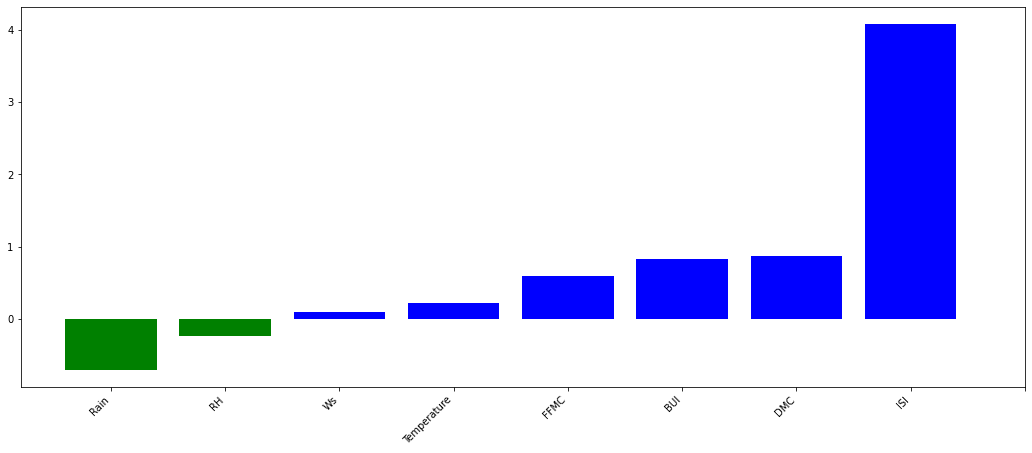

In [8]:
from sklearn import svm
import matplotlib.pyplot as plt
def feature_plot(classifier, feature_names, top_features=4):
 coef = classifier.coef_.ravel()
 top_positive_coefficients = np.argsort(coef)[-top_features:]
 top_negative_coefficients = np.argsort(coef)[:top_features]
 top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
 plt.figure(figsize=(18, 7))
 colors = ['green' if c < 0 else 'blue' for c in coef[top_coefficients]]
 plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
 feature_names = np.array(feature_names)
 plt.xticks(np.arange(1 + 2 * top_features), feature_names[top_coefficients], rotation=45, ha='right')
 plt.show()

print(fires_train.drop(['Classes'], axis = 1).columns.values)

trainedsvm = svm.LinearSVC().fit(fires, target)
feature_plot(trainedsvm, fires_train.drop(['Classes'], axis = 1).columns.values)

In [9]:
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
C_range = [0.01, 0.1, 1, 10,100]  
gamma_range = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
svcModel = SVC(kernel='rbf',max_iter = 1000)
parameters = {'C':C_range, 'gamma':gamma_range}
clf1 = GridSearchCV(svcModel, parameters, cv=10, n_jobs=-1)
clf1.fit(fires, target)

c1 = clf1.best_params_['C']
gamma1 = clf1.best_params_['gamma']

print('c1 value is', c1, 'gamma1 value is', gamma1)

c1 value is 100 gamma1 value is 0.1


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [10]:
svcModel1 = SVC(C=c1, gamma=gamma1,kernel='rbf')
svc_family = svcModel1.fit(fires, target)
pred = svc_family.predict(firestst)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [11]:
from sklearn.metrics import accuracy_score
q = accuracy_score(targettst,pred)
q

0.75

In [13]:
from sklearn.metrics import accuracy_score
q = accuracy_score(targettst,pred_test_rbf)
r = accuracy_score(targettst,pred_test_linear)
print( "Test RBF Accuracy=", q, "Test Linear Accuracy=", r)

Test RBF Accuracy= 0.8333333333333334 Test Linear Accuracy= 0.85


Test F1_score= 0.8363636363636363 Test Accuracy= 0.85


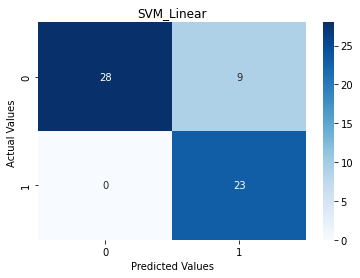

In [14]:
F1_score, Accuracy = metrics(targettst,pred_test_linear, "SVM_Linear")
print("Test F1_score=", F1_score, "Test Accuracy=", Accuracy)

Test RBF F1_score= 0.8214285714285715 Test RBF Accuracy= 0.8333333333333334


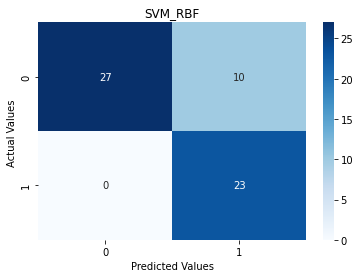

In [15]:
F1_score, Accuracy = metrics(targettst,pred_test_rbf, "SVM_RBF")
print("Test RBF F1_score=", F1_score, "Test RBF Accuracy=", Accuracy)

In [17]:
#After feature Engineering
# Droping the 1st Least prominnent Feature 
# Drop Temperature

In [22]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

fires_train = pd.read_csv("/content/EE559_Project-main/datasets/algerian_fires_train.csv")
fires_test = pd.read_csv("/content/EE559_Project-main/datasets/algerian_fires_test.csv")

data = fires_train.describe()
tstdata = fires_test.describe()
#1drop temperature
fires_trainx = fires_train.iloc[:,2:-1]
fires_trainy = fires_train.iloc[:,-1]
fires_testx = fires_test.iloc[:,2:-1]
fires_testy = fires_test.iloc[:,-1]
#2drop Temp,RH
fires_trainx_2 = fires_train.iloc[:,3:-1]
fires_trainy_2 = fires_train.iloc[:,-1]
fires_testx_2 = fires_test.iloc[:,3:-1]
fires_testy_2 = fires_test.iloc[:,-1]

#4drop
fires_trainx_4 = fires_train.iloc[:,5:-1]
fires_trainy_4 = fires_train.iloc[:,-1]
fires_testx_4 = fires_test.iloc[:,5:-1]
fires_testy_4 = fires_test.iloc[:,-1]

scalar = MinMaxScaler()

fires = scalar.fit_transform(fires_trainx)
firestst = scalar.fit_transform(fires_testx)
#2drop
fires_2 = scalar.fit_transform(fires_trainx_2)
firestst_2 = scalar.fit_transform(fires_testx_2)
#4drop
fires_4 = scalar.fit_transform(fires_trainx_4)
firestst_4 = scalar.fit_transform(fires_testx_4)


#1
model_linear = SVC(kernel = "linear")
model_linear.fit(fires,fires_trainy)
pred_test_linear = model_linear.predict(firestst)

# kernel = rbf
model_rbf = SVC(kernel = "rbf")
model_rbf.fit(fires,fires_trainy)
pred_test_rbf = model_rbf.predict(firestst)

#2drop
model_linear1 = SVC(kernel = "linear")
model_linear1.fit(fires_2,fires_trainy_2)
pred_test_linear1 = model_linear1.predict(firestst_2)

#test rbf
model_rbf1 = SVC(kernel = "rbf")
model_rbf1.fit(fires_2,fires_trainy_2)
pred_test_rbf1 = model_rbf1.predict(firestst_2)

# #4drop
model_linear4 = SVC(kernel = "linear")
model_linear4.fit(fires_4,fires_trainy_4)
# pred_test_linear4 = model_linear1.predict(firestst_4)

#test rbf
model_rbf4 = SVC(kernel = "rbf")
model_rbf4.fit(fires_4,fires_trainy_4)
pred_test_rbf4 = model_rbf4.predict(firestst_4)

In [31]:
model_linear5 = svm.LinearSVC().fit(fires_4, fires_trainy_4)
ans4 = model_linear5.predict(firestst_4)

Test linear 4 F1_score= 0.8214285714285715 Test linear 4  Accuracy= 0.8333333333333334


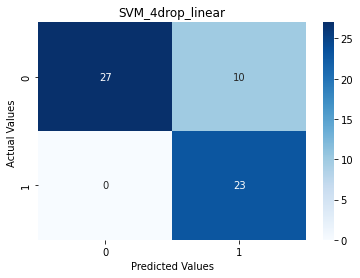

In [32]:
F1_score, Accuracy = metrics(fires_testy_4, ans4, "SVM_4drop_linear")

print("Test linear 4 F1_score=", F1_score, "Test linear 4  Accuracy=", Accuracy)

Test rbf 4 F1_score= 0.8070175438596492 Test rbf 4  Accuracy= 0.8166666666666667


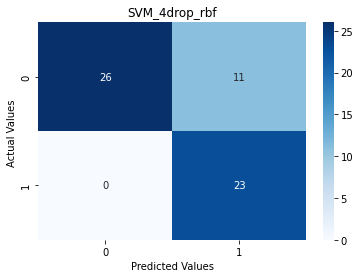

In [33]:
F1_score, Accuracy = metrics(fires_testy_4, pred_test_rbf4, "SVM_4drop_rbf")

print("Test rbf 4 F1_score=", F1_score, "Test rbf 4  Accuracy=", Accuracy)

Test Linear F1_score= 0.8363636363636363 Test Linear Accuracy= 0.85


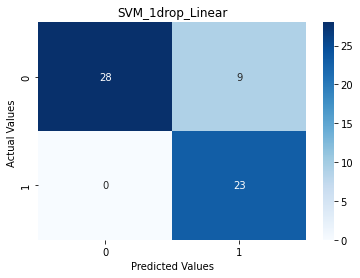

In [34]:
F1_score, Accuracy = metrics(fires_testy, pred_test_linear, "SVM_1drop_Linear")
print("Test Linear F1_score=", F1_score, "Test Linear Accuracy=", Accuracy)

Test RBF F1_score= 0.8214285714285715 Test RBF Accuracy= 0.8333333333333334


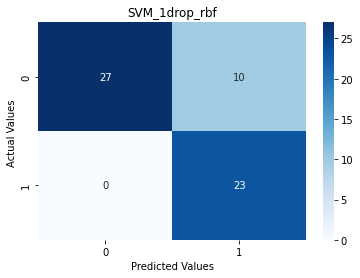

In [35]:
F1_score, Accuracy = metrics(fires_testy, pred_test_rbf, "SVM_1drop_rbf")
print("Test RBF F1_score=", F1_score, "Test RBF Accuracy=", Accuracy)

Test Linear 2drop F1_score= 0.8363636363636363 Test Linear 2drop Accuracy= 0.85


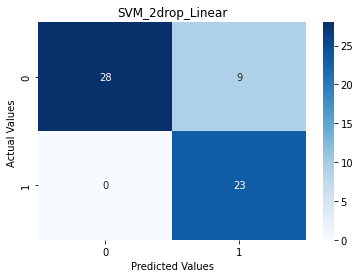

In [36]:
F1_score, Accuracy = metrics(fires_testy_2, pred_test_linear1, "SVM_2drop_Linear")
print("Test Linear 2drop F1_score=", F1_score, "Test Linear 2drop Accuracy=", Accuracy)

Test RBF 2drop F1_score= 0.8214285714285715 Test RBF 2drop Accuracy= 0.8333333333333334


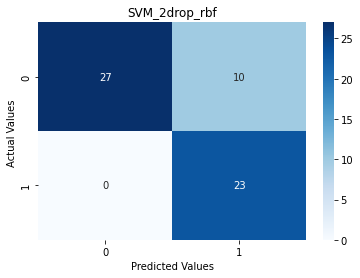

In [37]:
F1_score, Accuracy = metrics(fires_testy_2, pred_test_rbf1, "SVM_2drop_rbf")
print("Test RBF 2drop F1_score=", F1_score, "Test RBF 2drop Accuracy=", Accuracy)